In [1]:
import torch
import torch.nn as nn
import math
import joblib

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import joblib
import numpy as np
import random as rd
import soundfile as sf
import pytorch_lightning as pl
from tqdm import tqdm

!pip install wandb
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")

wandb.login(key=secret_value_0)

In [2]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [4]:
datas = joblib.load("/kaggle/input/maestroromantic5/Maestro_Rolls_Romantic5_train.pkl")
datas_val = joblib.load("/kaggle/input/maestroromantic5/Maestro_Rolls_Romantic5_test.pkl")

In [5]:
S = 1

index = []
for song_idx, song in enumerate(datas):
    for frag_idx in range(len(song)):
        index.append((song_idx, frag_idx))

index_val = []
for song_idx, song in enumerate(datas_val):
    for frag_idx in range(len(song)):
        index_val.append((song_idx, frag_idx))

class FragmentDataset(Dataset):
    def __init__(self, data, index):
        self.data = data
        self.index = index 

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        song_idx, frag_idx = self.index[idx]
        fragment = self.data[song_idx][frag_idx] 
        fragment = fragment[np.newaxis, :, :] 
        return torch.tensor(fragment, dtype=torch.float32)

dataset = FragmentDataset(datas, index)
val_dataset = FragmentDataset(datas_val, index_val)


dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
print(len(dataloader), len(val_dataloader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

1592 440


device(type='cuda')

In [6]:
class VectorQuantizer(nn.Module):
    """Vector Quantization layer for VQ-VAE (without EMA)"""

    def __init__(self, num_embed, embed_dim, beta):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embed_dim
        self._num_embeddings = num_embed

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1 / self._num_embeddings, 1 / self._num_embeddings)
        self._commitment_cost = beta

    def forward(self, inputs):
        B, C, H_latent, W_latent = inputs.shape

        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape 

        flat_input = inputs.view(-1, self._embedding_dim) 

        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1) 

        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices.view(B, H_latent, W_latent)


class VectorQuantizerEMA(nn.Module):

    def __init__(self, num_embed, embed_dim, beta, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embed_dim
        self._num_embeddings = num_embed

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = beta

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embed))
        self._ema_w = nn.Parameter(torch.Tensor(num_embed, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        B, C, H_latent, W_latent = inputs.shape

        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        flat_input = inputs.view(-1, self._embedding_dim) 

        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                        (self._ema_cluster_size + self._epsilon)
                        / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w.data.copy_(self._ema_w * self._decay + (1 - self._decay) * dw) # Use .copy_() for in-place update

            self._embedding.weight.data.copy_(self._ema_w / self._ema_cluster_size.unsqueeze(1)) # Use .copy_()

        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices.view(B, H_latent, W_latent)


class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 1, bias=False), 
        )
    def forward(self, x):
        return x + self.block(x)


class ResidualStack(nn.Module):
    def __init__(self, dim, num_residual=2):
        super(ResidualStack, self).__init__()
        self.num_residual = num_residual
        self.layers = nn.ModuleList([ResBlock(dim) for _ in range(num_residual)])

    def forward(self, x):
        for i in range(self.num_residual):
            x = self.layers[i](x)
        return x


class VectorQuantizedVAE(nn.Module):
    def __init__(self, inc, num_embed=256, embed_dim=128, num_residual=2, beta=0.25, decay=0.99):
        super(VectorQuantizedVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(inc, embed_dim, 4, 2, 1, bias=False), # Downsamples by 2
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(True),
            nn.Conv2d(embed_dim, embed_dim, 4, 2, 1, bias=False), # Downsamples by 2
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(True),
            nn.Conv2d(embed_dim, embed_dim, 4, 2, 1, bias=False), # Downsamples by 2
            ResidualStack(embed_dim, num_residual) # No BatchNorm/ReLU after last conv before ResidualStack as per VQ-VAE paper
        )

        # Select VQ layer based on decay parameter
        self.codebook = VectorQuantizerEMA(num_embed, embed_dim, beta, decay) if decay > 0.0 else VectorQuantizer(num_embed, embed_dim, beta)

        self.decoder = nn.Sequential(
            ResidualStack(embed_dim, num_residual),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(embed_dim, embed_dim, 4, 2, 1, bias=False), # Upsamples by 2
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(embed_dim, embed_dim, 4, 2, 1, bias=False), # Upsamples by 2
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(embed_dim, inc, 4, 2, 1), # Upsamples by 2, output to original channels
        )

    def forward(self, x):
        z = self.encoder(x)
        q_loss, quantized, perplexity, encoding_indices = self.codebook(z)
        x_recon = self.decoder(quantized)

        return q_loss, x_recon, perplexity, encoding_indices

    def get_codebooks_idx(self, x):
        z = self.encoder(x)
        _, _, _, codebooks_idx = self.codebook(z)
        return codebooks_idx

    def decode_from_latent_indices(self, indices):
        quantized_flat = self.codebook._embedding(indices)
        quantized = quantized_flat.permute(0, 3, 1, 2).contiguous()  # BHWC -> BCHW

        return self.decoder(quantized)


class PianorollVQVAELightning(pl.LightningModule):

    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams) # Saves hyperparameters to self.hparams

        self.vqvae = VectorQuantizedVAE(
            inc=hparams['in_channels'],
            num_embed=hparams['num_embeddings'],
            embed_dim=hparams['embedding_dim'],
            num_residual=hparams['num_residual_layers'], # Map to num_residual
            beta=hparams['commitment_cost'],
            decay=hparams.get('decay', 0.99) # Use decay if provided, else default to 0.99
        )

    def forward(self, x):
        return self.vqvae(x)

    def _common_step(self, batch, batch_idx, step_type: str):
        x = batch.float()
        x[x > 0] = 1
        x[x < 1] = 0
    
        q_loss, x_recon, perplexity, indices = self(x)
    
        # Weighted BCEWithLogitsLoss for handling imbalance
        pos_weight = torch.tensor([22], device=x.device)
        recon_loss = F.binary_cross_entropy_with_logits(
            x_recon, x, reduction='mean', pos_weight=pos_weight
        )
    
        total_loss = recon_loss + self.hparams.beta * q_loss
    
        # Logging
        self.log(f'{step_type}/recon_loss', recon_loss, prog_bar=(step_type == 'train'))
        self.log(f'{step_type}/vq_loss', q_loss, prog_bar=(step_type == 'train'))
        self.log(f'{step_type}/total_loss', total_loss, prog_bar=(step_type == 'train'))
        self.log(f'{step_type}/perplexity', perplexity, prog_bar=(step_type == 'train'))
    
        return total_loss

    
    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, step_type='train')
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, step_type='val')
    
    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, step_type='test')

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.learning_rate)
        if self.trainer is not None and self.trainer.datamodule is not None:
            total_training_steps = self.trainer.max_epochs * len(self.trainer.datamodule.train_dataloader())
        else:
            print("Warning: Dataloader info not available for LR scheduler T_max calculation. Using a fixed T_max.")
            total_training_steps = 1000 # Arbitrary large number

        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_training_steps, eta_min=1e-6)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val/total_loss', # Metric to monitor for scheduling
                'interval': 'step', # Apply scheduler every step for CosineAnnealingLR
                'frequency': 1
            }
        }

    def encode(self, x):
        return self.vqvae.get_codebooks_idx(x)

    def decode_indices(self, indices):
        return self.vqvae.decode_from_latent_indices(indices)

In [7]:
vqvae = torch.load("/kaggle/input/vqromanticnt_128/pytorch/default/1/VqMidi_Maestro_nt128_9mln_ch1.pt", weights_only=False).to('cuda')

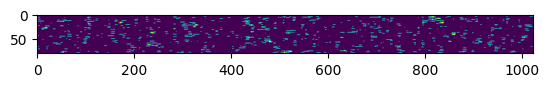

tensor([[[ 97,  54,  54,  ..., 107, 105,  74],
         [ 97, 109,  54,  ..., 100, 123, 105],
         [ 97,  97,   1,  ...,  34,  13,  37],
         ...,
         [ 97,  54,  54,  ...,  75,   1,  70],
         [ 97,  54,  54,  ..., 126,  78,   5],
         [ 97,  54,  54,  ...,   1,   1,  74]]], device='cuda:0')


In [18]:
tresh = 0.7
with torch.no_grad():
    reconstructed_output = vqvae.vqvae.decode_from_latent_indices(torch.randint(0, 128, size=(1, 10, 128), device=vqvae.device))

reconstructed_output[reconstructed_output > tresh] = 1
reconstructed_output[reconstructed_output <= tresh] = 0
plt.imshow(reconstructed_output[0, 0].cpu().numpy())
plt.show()
print(vqvae.vqvae.get_codebooks_idx(dataset[5].to(device).unsqueeze(0)).permute(0, 2, 1))

In [9]:
# MODEL
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class RoPEEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=2048, base=10000):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        self.base = base
        
        # Precompute frequency tensor
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        
        # Precompute cos and sin for efficiency
        t = torch.arange(max_seq_len, dtype=torch.float)
        freqs = torch.outer(t, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer('cos_cached', emb.cos())
        self.register_buffer('sin_cached', emb.sin())
    
    def rotate_half(self, x):
        """Rotates half the hidden dims of the input."""
        x1 = x[..., : x.shape[-1] // 2]
        x2 = x[..., x.shape[-1] // 2 :]
        return torch.cat((-x2, x1), dim=-1)
    
    def forward(self, q, k, seq_len):
        cos = self.cos_cached[:seq_len, ...]
        sin = self.sin_cached[:seq_len, ...]
        
        q_embed = (q * cos) + (self.rotate_half(q) * sin)
        k_embed = (k * cos) + (self.rotate_half(k) * sin)
        
        return q_embed, k_embed

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, max_seq_len=2048):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.rope = RoPEEmbedding(self.d_k, max_seq_len)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        q = self.w_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        k = self.w_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        v = self.w_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        q, k = self.rope(q, k, seq_len)
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        
        if mask is not None:
            scores.masked_fill_(mask == 0, -1e9)
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        attn_output = torch.matmul(attn_weights, v)
        
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )
        
        return self.w_o(attn_output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, max_seq_len=2048):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout, max_seq_len)
        # self.attention = nn.MultiHeadAttention()
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attn_out = self.attention(self.norm1(x), mask)
        x = x + self.dropout(attn_out)
        
        ff_out = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_out)
        
        return x

class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_heads=8, n_layers=6, 
                 d_ff=2048, max_seq_len=2048, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, dropout, max_seq_len)
            for _ in range(n_layers)
        ])
        
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=True)
        
        self.dropout = nn.Dropout(dropout)    
    
    def create_causal_mask(self, seq_len, device):
        mask = torch.tril(torch.ones((seq_len, seq_len), device=device))
        return mask.unsqueeze(0).unsqueeze(0) 
    
    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_len = input_ids.shape
        
        x = self.token_embedding(input_ids) * math.sqrt(self.d_model)
        x = self.dropout(x)
        
        causal_mask = self.create_causal_mask(seq_len, input_ids.device)
        
        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            causal_mask = causal_mask * attention_mask
        
        for block in self.blocks:
            x = block(x, causal_mask)
        
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        return logits
    
    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens=1000, temperature=1.0, top_k=50):
        self.eval()
        
        for _ in range(max_new_tokens):
            logits = self.forward(input_ids)
            
            last_logits = logits[:, -1, :] / temperature
            
            if top_k > 0:
                values, indices = torch.topk(last_logits, top_k)
                last_logits[last_logits < values[:, -1:]] = -float('inf')
            
            probs = F.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            input_ids = torch.cat([input_ids, next_token], dim=-1)
            
            if input_ids.shape[1] > self.max_seq_len:
                input_ids = input_ids[:, -self.max_seq_len:]
        
        return input_ids

In [10]:
# LGHT
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch.optim import AdamW

class LitTransformer(pl.LightningModule):
    def __init__(self, vocab_size, d_model=1024, n_heads=8, n_layers=12, d_ff=1024, max_seq_len=1280, dropout=0.1, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleTransformer(
            vocab_size=vocab_size,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            d_ff=d_ff,
            max_seq_len=max_seq_len,
            dropout=dropout
        )
        self.lr = lr

    def forward(self, input_ids):
        return self.model(input_ids)

    def _shared_step(self, batch):
        x = batch.float().to(self.device)
        x = vqvae.vqvae.get_codebooks_idx(x)
        x = x.permute(0, 2, 1).flatten(1)

        input_ids = x[:, :-1]
        targets = x[:, 1:]

        logits = self(input_ids)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.reshape(-1))
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._shared_step(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        val_loss = self._shared_step(batch)
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.lr)


In [ ]:

def generate_sequences(model, vqvae, start_token_idx, num_sequences=1, max_new_tokens=100, temperature=1.0, top_k=50, sequence_length=None):
    model.eval()
    generated_sequences = []

    print(f"Generating {num_sequences} sequences...")
    for _ in tqdm(range(num_sequences)):
        input_ids = torch.tensor([[start_token_idx]], dtype=torch.long, device=device)
        
        generated_ids = model.generate(input_ids, max_new_tokens, temperature, top_k)
        
        generated_sequences.append(generated_ids)
    
    return generated_sequences


In [11]:
# EXPAND A PIANOROLL TO 128 PITCH (NEEDED for the synthesis function)
def to_128(x):
    mapped = torch.zeros((128, x.shape[1]))
    mapped[20:100, :] = x
    return mapped

# FUNCTIONS
!pip install pretty_midi
import pretty_midi
S = 1
def S_to_pitch(pitch):
    return pitch + (S-1) if pitch % 2 == 1 else pitch

def multi_hot_to_midi(piano_roll: np.ndarray, time_per_step: float = 0.03,
                      velocity: int = 100) -> pretty_midi.PrettyMIDI:
    print(piano_roll.shape)
    T, n_pitches = piano_roll.shape
    if n_pitches != 128:
        raise ValueError("The input piano roll must have 128 columns (for MIDI notes 0-127).")

    midi_obj = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    active_notes = {}

    for t in range(T):
        current_time = t * time_per_step
        current_frame = piano_roll[t]  # shape: (128,)

        for pitch in range(128):
            is_active = current_frame[pitch] > 0
            prev_active = piano_roll[t - 1][pitch] > 0 if t > 0 else False

            if is_active and not prev_active:
                active_notes[pitch] = current_time
            elif not is_active and prev_active:
                start_time = active_notes.pop(pitch, current_time)
                note = pretty_midi.Note(velocity=velocity, pitch=S_to_pitch(pitch)+12, start=start_time, end=current_time)
                instrument.notes.append(note)

    final_time = T * time_per_step
    for pitch, start_time in active_notes.items():
        note = pretty_midi.Note(velocity=velocity, pitch=S_to_pitch(pitch)+12, start=start_time, end=final_time)
        instrument.notes.append(note)

    midi_obj.instruments.append(instrument)
    return midi_obj

def midi_to_audio(midi_path, fs=44100, tempo=100, autoplay=False):
    pm = midi_path                                                

    wav = pm.synthesize(fs)                                          
    wav = wav / np.max(np.abs(wav))                                  
    return Audio(wav, rate=fs, autoplay=autoplay)   

import pretty_midi
import matplotlib.pyplot as plt
import numpy as np

def plot_midi_pianoroll(midi_path, fs=100):
    pm = midi_path
    
    piano_roll = pm.get_piano_roll(fs=fs)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='gray_r', 
               extent=[0, piano_roll.shape[1] / fs, 0, 128])
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Pitch')
    plt.title('Piano Roll')
    plt.colorbar(label='Velocity')
    plt.tight_layout()
    plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=a4341d4ea292cbc8a1a7fafe47ef619f88c900642221609daaee95a1bf9ccc65
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


from pytorch_lightning.loggers import WandbLogger
wandb.finish()
wandb_logger = WandbLogger(
    project="transformer-vqvae-romantic",
    name="lit-transformer-run2", 
    log_model=False             
)

In [12]:
model = torch.load('/kaggle/input/vqmuserromantic2_30mln/pytorch/default/1/VqMuserRomantic2_50_checkpoint_ep_9.pt', weights_only=False).to(device)

torch.cuda.empty_cache()
import gc; gc.collect()

from pytorch_lightning import Trainer

model = LitTransformer(vocab_size=128)

trainer = Trainer(
    max_epochs=9,
    accelerator='gpu',
    devices=-1,
    precision=32,
    log_every_n_steps=10,
    val_check_interval=0.1,
    logger=wandb_logger
)

trainer.fit(model, train_dataloaders=dataloader, val_dataloaders=val_dataloader)


In [ ]:
model = SimpleTransformer(
            vocab_size=128,
            d_model=512,
            n_heads=8,
            n_layers=16,
            d_ff=1024,
            max_seq_len=1280,
            dropout=0.1
        )
model = torch.nn.DataParallel(model.to(device))
optim = AdamW(model.parameters(), lr=1e-4)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params:_}")

In [ ]:
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F

train_epoch_lossess = []
val_epoch_lossess = []
made_epochs = 8

In [ ]:
for epoch in range(4):
    train_loss = 0
    val_loss = 0

    train_lossess = []
    val_lossess = []

    pbar_train = tqdm(dataloader, desc=f"Epoch {epoch+1}/1 (Training)", leave=False)
    for i, batch in enumerate(pbar_train):
        x = batch.float().to(device)
        x = vqvae.vqvae.get_codebooks_idx(x)
        x = x.permute(0, 2, 1).flatten(1)

        input_ids = x[:, :-1]
        targets = x[:, 1:]

        logits = model(input_ids)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.reshape(-1))

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item()
        train_lossess.append(loss.item())

        pbar_train.set_postfix(loss=loss.item())

    pbar_val = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/1 (Validation)", leave=False)
    for i, batch in enumerate(pbar_val):
        with torch.no_grad():
            x = batch.float().to(device)
            x = vqvae.vqvae.get_codebooks_idx(x)
            x = x.permute(0, 2, 1).flatten(1)

            input_ids = x[:, :-1]
            targets = x[:, 1:]

            logits = model(input_ids)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.reshape(-1))
            val_loss += loss.item()
            val_lossess.append(loss.item())

        pbar_val.set_postfix(loss=loss.item())

    train_loss = train_loss / len(dataloader)
    val_loss = val_loss / len(val_dataloader)

    train_epoch_lossess.append(train_loss)
    val_epoch_lossess.append(val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    made_epochs += 1
    torch.save(model, f'VqMuserRomantic2_50_checkpoint_ep_{made_epochs}.pt')
    plt.title("Epoch Losses")
    plt.plot(train_lossess)
    plt.plot(val_lossess)
    
    plt.show()

    plt.title("Total Losses, once per epoch")
    plt.plot(train_epoch_lossess)
    plt.plot(val_epoch_lossess)
    
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_lossess)
plt.plot(val_lossess)

plt.show()

In [ ]:
torch.save(model, 'ext4_checkpoint.pt')

In [13]:
def generate_sequences(model, vqvae, start_token_idx, num_sequences=1, max_new_tokens=100, temperature=1.0, top_k=50, sequence_length=None):
    model.eval()
    generated_sequences = []

    print(f"Generating {num_sequences} sequences...")
    for _ in tqdm(range(num_sequences)):
        input_ids = torch.tensor([[start_token_idx]], dtype=torch.long, device=device)
        generated_ids = model.generate(input_ids, max_new_tokens, temperature, top_k)
        
        generated_sequences.append(generated_ids)
    
    return generated_sequences

In [38]:
start_token_idx = 94

num_generated_sequences = 1
max_tokens_to_generate = 1279

generated_code_sequences = generate_sequences(
    model.module, 
    vqvae, 
    start_token_idx=start_token_idx, 
    num_sequences=num_generated_sequences, 
    max_new_tokens=max_tokens_to_generate, 
    temperature=0.9, 
    top_k=50,
    sequence_length=max_tokens_to_generate
)

print("\nGenerated Codebook Sequences (first few tokens of each):")
for i, seq in enumerate(generated_code_sequences):
    print(f"Sequence {i+1}: {seq[0, :min(20, seq.shape[1])].tolist()}...")
tresh = 0.7
with torch.no_grad():
    generated = vqvae.decode_indices(generated_code_sequences[0].view(1, 128, 10).permute(0, 2, 1))
    generated.shape
    generated = torch.sigmoid(generated)

print(generated_code_sequences[0])
plt.imshow(generated[0, 0].cpu().numpy())
plt.show()

generated[generated > tresh] = 1
generated[generated <= tresh] = 0

tolisten = generated
tolisten = tolisten.squeeze(1)
_sample = to_128(tolisten[0].cpu())
print(_sample.shape)
midi = multi_hot_to_midi(_sample.cpu().numpy().T)
plot_midi_pianoroll(midi)
from IPython.display import Audio
midi.write('gen1.mid')
midi_to_audio(midi)

Generating 1 sequences...


  0%|          | 0/1 [00:27<?, ?it/s]


KeyboardInterrupt: 

▶️ Starting generation from a prompt of 4 tokens.
   Generating 1276 new tokens to reach a total length of 1280.

✅ Generation complete.
   Final sequence shape: torch.Size([1, 1280])

Generated Codebook Sequence (first 20 tokens):
[97, 97, 97, 54, 60, 20, 86, 32, 20, 115, 97, 54, 54, 54, 60, 20, 86, 32, 20, 115]

Decoded tensor shape: torch.Size([1, 1, 80, 1024])


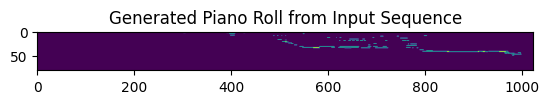

Shape after processing for MIDI: torch.Size([128, 1024])
(1024, 128)


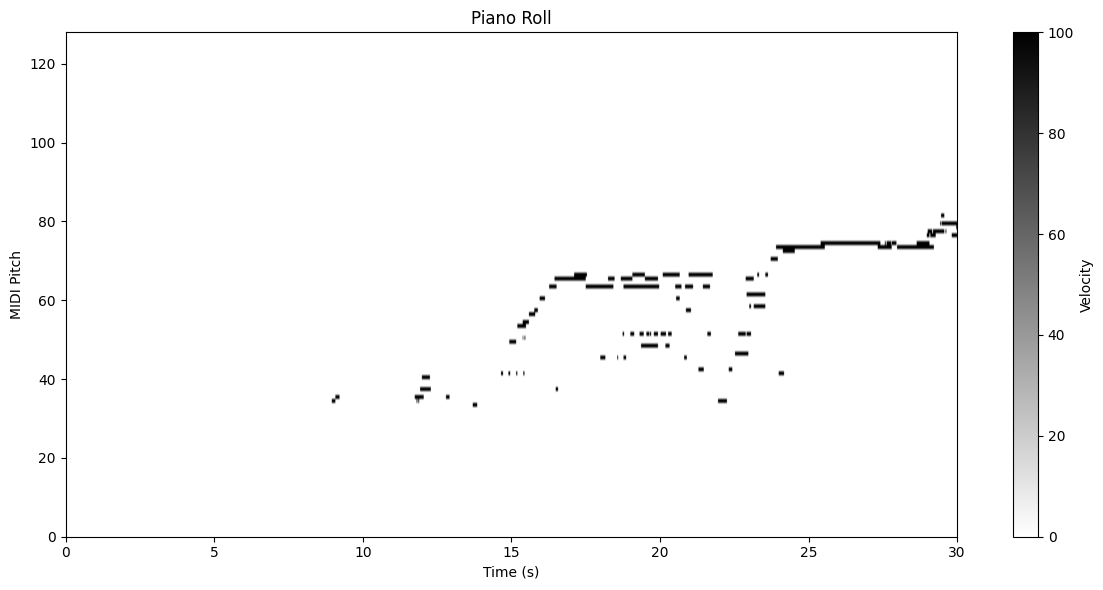


🎶 MIDI file saved as 'gen2.mid'


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

input_tokens_list = [97, 97, 97, 54]
total_sequence_length = 1280
temperature = 1.0
top_k = 45      
tresh = 0.5        

prompt_sequence = torch.tensor([input_tokens_list], dtype=torch.long, device=device)
num_prompt_tokens = prompt_sequence.shape[1]
max_new_tokens = total_sequence_length - num_prompt_tokens


generated_code_sequences = prompt_sequence
print(f"▶️ Starting generation from a prompt of {num_prompt_tokens} tokens.")
print(f"   Generating {max_new_tokens} new tokens to reach a total length of {total_sequence_length}.")

with torch.no_grad():  
    model.module.eval()

    for _ in range(max_new_tokens):
        logits = model.module(generated_code_sequences)
        next_token_logits = logits[:, -1, :]
        next_token_logits = next_token_logits / temperature
        v, _ = torch.topk(next_token_logits, min(top_k, next_token_logits.size(-1)))
        next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        generated_code_sequences = torch.cat((generated_code_sequences, next_token), dim=1)

print("\n✅ Generation complete.")
print(f"   Final sequence shape: {generated_code_sequences.shape}")

print("\nGenerated Codebook Sequence (first 20 tokens):")
print(f"{generated_code_sequences[0, :min(20, generated_code_sequences.shape[1])].tolist()}")

with torch.no_grad():
    indices_for_decoder = generated_code_sequences.view(1, 128, 10).permute(0, 2, 1)

    generated = vqvae.decode_indices(indices_for_decoder)
    generated = torch.sigmoid(generated)

print(f"\nDecoded tensor shape: {generated.shape}")

generated[generated > tresh] = 1
generated[generated <= tresh] = 0

plt.imshow(generated[0, 0].cpu().numpy())
plt.title("Generated Piano Roll from Input Sequence")
plt.show()

tolisten = generated.squeeze(1)
_sample = to_128(tolisten[0].cpu()) 
print(f"Shape after processing for MIDI: {_sample.shape}")

midi = multi_hot_to_midi(_sample.cpu().numpy().T)
plot_midi_pianoroll(midi)

output_filename = 'gen2.mid'
midi.write(output_filename)
print(f"\n🎶 MIDI file saved as '{output_filename}'")

midi_to_audio(midi)

mytest = torch.tensor(datas_val[49], device=device)

sample_input =  mytest.unsqueeze(1).float()
sample_input[sample_input > 0] = 1
sample_input[sample_input < 1] = 0
with torch.no_grad():
    _, reconstructed_output, _, indicies = vqvae(sample_input)
    # reconstructed_output = vqvae.decode_indices(generated_code_sequences[0].view(1, 128, 10).permute(0, 2, 1))
    reconstructed_output = vqvae.decode_indices(indecies)

print(indicies.shape)
reconstructed_output = torch.sigmoid(reconstructed_output)
plt.imshow(sample_input[0, 0].cpu().numpy())
plt.show()
plt.imshow(reconstructed_output[0, 0].cpu().numpy())
plt.show()
tresh = 0.995
reconstructed_output[reconstructed_output > tresh] = 1
reconstructed_output[reconstructed_output <= tresh] = 0
plt.imshow(reconstructed_output[0, 0].cpu().numpy())
plt.show()

tolisten = reconstructed_output
tolisten = tolisten.squeeze(1)
_sample = to_128(tolisten[0].cpu())
print(_sample.shape)
midi = multi_hot_to_midi(_sample.cpu().numpy().T)
plot_midi_pianoroll(midi)
from IPython.display import Audio
midi.write('bachfromergen.mid')
midi_to_audio(midi)

In [ ]:
def entropy_and_perplexity(indices_tensor):
    indices_flat = indices_tensor.flatten()
    counts = torch.bincount(indices_flat)
    probs = counts.float() / counts.sum()
    probs = probs[probs > 0]
    entropy = -torch.sum(probs * torch.log2(probs))
    perplexity = 2 ** entropy
    return entropy.item(), perplexity.item()


In [ ]:
entropy_and_perplexity(generated_code_sequences[0].view(1, 128, 10).permute(0, 2, 1))

In [ ]:
entropy_and_perplexity(indicies[:, :, :])